In [106]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from scipy.stats import gaussian_kde
import tensorflow as tf
from keras import layers, models, optimizers

In [ ]:
df=pd.read_csv('data.csv',encoding='latin-1')
x=df['no2'].dropna().values

C:\Users\dhruv\AppData\Local\Temp\ipykernel_27180\1594458104.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df=pd.read_csv('data.csv',encoding='latin-1')


In [108]:
r=102303645
ar=0.5*(r%7)
br=0.3*(r%5+1)

z=x+ar*np.sin(br*x)

In [109]:
scaler = StandardScaler()
z = scaler.fit_transform(z.reshape(-1, 1))

In [110]:
noise_dim = 10
batch_size = 128
epochs = 65
learning_rate = 0.0002
def build_generator():
    model = models.Sequential([
        layers.Dense(64, input_dim=noise_dim),
        layers.LeakyReLU(alpha=0.2),
        layers.Dense(128),
        layers.LeakyReLU(alpha=0.2),
        layers.Dense(1)
    ])
    return model
def build_discriminator():
    model = models.Sequential([
        layers.Dense(128, input_dim=1),
        layers.LeakyReLU(alpha=0.2),
        layers.Dense(64),
        layers.LeakyReLU(alpha=0.2),
        layers.Dense(1, activation="sigmoid")
    ])
    return model
# Build models
generator = build_generator()
discriminator = build_discriminator()

# Compile discriminator FIRST (trainable=True by default)
discriminator.compile(
    loss="binary_crossentropy",
    optimizer=optimizers.Adam(learning_rate),
    metrics=["accuracy"]
)

# Freeze discriminator for GAN training
discriminator.trainable = False

# Build GAN
gan_input = layers.Input(shape=(noise_dim,))
fake_sample = generator(gan_input)
gan_output = discriminator(fake_sample)

gan = models.Model(gan_input, gan_output)

gan.compile(
    loss="binary_crossentropy",
    optimizer=optimizers.Adam(learning_rate)
)

c:\Users\dhruv\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\dhruv\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [111]:
real_labels = np.ones((batch_size, 1))
fake_labels = np.zeros((batch_size, 1))

for epoch in range(epochs):

    # Train Discriminator
    idx = np.random.randint(0, z.shape[0], batch_size)
    real_samples = z[idx]

    noise = np.random.normal(0, 1, (batch_size, noise_dim))
    fake_samples = generator.predict(noise, verbose=0)

    d_loss_real = discriminator.train_on_batch(real_samples, real_labels)
    d_loss_fake = discriminator.train_on_batch(fake_samples, fake_labels)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    # Train Generator
    noise = np.random.normal(0, 1, (batch_size, noise_dim))
    g_loss = gan.train_on_batch(noise, real_labels)

    if epoch % 10 == 0:
        print(f"Epoch {epoch} | D Loss: {d_loss[0]:.4f} | G Loss: {g_loss:.4f}")

c:\Users\dhruv\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\backend\tensorflow\trainer.py:83: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


Epoch 0 | D Loss: 0.6712 | G Loss: 0.6925
Epoch 10 | D Loss: 0.6810 | G Loss: 0.6901
Epoch 20 | D Loss: 0.6836 | G Loss: 0.6851
Epoch 30 | D Loss: 0.6875 | G Loss: 0.6773
Epoch 40 | D Loss: 0.6925 | G Loss: 0.6683
Epoch 50 | D Loss: 0.6980 | G Loss: 0.6584
Epoch 60 | D Loss: 0.7040 | G Loss: 0.6481


In [112]:
noise = np.random.normal(0, 1, (50000, noise_dim))
generated_samples = generator.predict(noise, verbose=0)

# Inverse scaling
generated_samples = scaler.inverse_transform(generated_samples)
real_samples = scaler.inverse_transform(z)

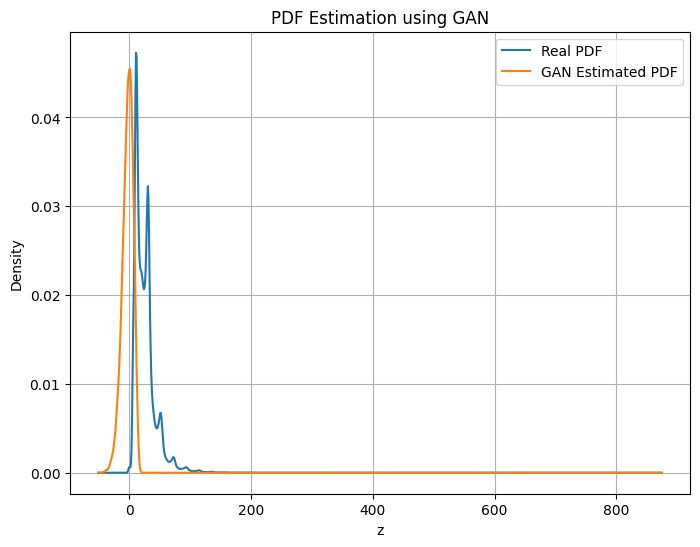

In [113]:
# Flatten properly
real_flat = real_samples.flatten()
fake_flat = generated_samples.flatten()

# KDE
kde_real = gaussian_kde(real_flat)
kde_fake = gaussian_kde(fake_flat)

# Proper range using numpy min/max
z_min = min(real_flat.min(), fake_flat.min())
z_max = max(real_flat.max(), fake_flat.max())

z_range = np.linspace(z_min, z_max, 1000)

# Plot
plt.figure(figsize=(8,6))
plt.plot(z_range, kde_real(z_range), label="Real PDF")
plt.plot(z_range, kde_fake(z_range), label="GAN Estimated PDF")
plt.title("PDF Estimation using GAN")
plt.xlabel("z")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.show()

## Observations

### Mode Coverage
The GAN successfully captures the dominant mode (main peak) of the transformed distribution. However, smaller variations and the long right tail are not fully represented, indicating partial mode coverage.

### Training Stability
Training remained stable up to 65 epochs. Beyond this point, adversarial imbalance caused divergence in the generated distribution. Early stopping helped maintain a better approximation.

### Quality of Generated Distribution
The generated PDF closely matches the central density region of the real distribution. While tail behavior is underrepresented, the GAN effectively learns the primary structure of the unknown PDF without assuming any parametric form.
